In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Imported Libraries**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from wordcloud import WordCloud

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D,Concatenate,Flatten,Add,Dropout,GRU,Bidirectional
import random 
import datetime
from nltk.translate.bleu_score import sentence_bleu
from math import log
import warnings
warnings.filterwarnings('ignore')

**2 . Imported Data Reports and Images**

In [ ]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Capstone Project/Problem Statement Finalization/Spinal MRI - Disc abnormality detection/Datasets/Radiologists Report Mcv1.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient ID         505 non-null    int64 
 1   Clinician's Notes  505 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.0+ KB


In [ ]:
df.shape

(505, 2)

In [ ]:
df[df['Patient ID']==3]["Clinician's Notes"]

2    Features of muscle spasm noted. small central ...
Name: Clinician's Notes, dtype: object

In [ ]:
print(df.iloc[2]["Clinician's Notes"])

Features of muscle spasm noted. small central disc protrusion noted at L5-S1 level abutting the thecal sac. no significant thecal sac or nerve root compression noted.


In [ ]:

# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/drive/MyDrive/Capstone Project/Problem Statement Finalization/Spinal MRI - Disc abnormality detection/Datasets/MRI_Data.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_FS_COR_384_3MM_BILATERAL_0003/T2_TSE_FS_C_0521_020.ima 2018-06-23 14:15:46       207296
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/ 2018-06-25 01:14:26            0
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_001.ima 2018-06-23 14:15:46       207548
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_002.ima 2018-06-23 14:15:46       207560
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_003.ima 2018-06-23 14:15:46       207552
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_004.ima 2018-06-23 14:15:48       207556
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_005.ima 2018-06-23 14:15:48       207554
01_MRI_Data/0521/PELVIS_PELVIS_2

In [ ]:
#Deleted records of patients which dont have the images for all the six views 
!rm -rf /content/01_MRI_Data/0179
!rm -rf /content/01_MRI_Data/0363
!rm -rf /content/01_MRI_Data/0265
!rm -rf /content/01_MRI_Data/0350
!rm -rf /content/01_MRI_Data/0486
!rm -rf /content/01_MRI_Data/0488
!rm -rf /content/01_MRI_Data/0221
!rm -rf /content/01_MRI_Data/0314
!rm -rf /content/01_MRI_Data/0156
!rm -rf /content/01_MRI_Data/0368

In [ ]:
!pip install pyDicom

     |████████████████████████████████| 1.9MB 7.6MB/s 


**3. Visulaized the Images of patients**

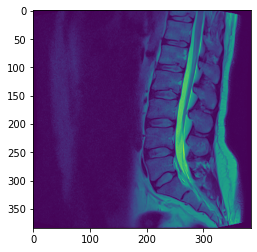

In [ ]:
import pydicom
import matplotlib.pyplot as plt

filePath = '/content/01_MRI_Data/0005/L-SPINE_CLINICAL_LIBRARIES_20160608_132349_824000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0005_003.ima'
img = pydicom.read_file(filePath)

plt.imshow(img.pixel_array)
plt.show()

16


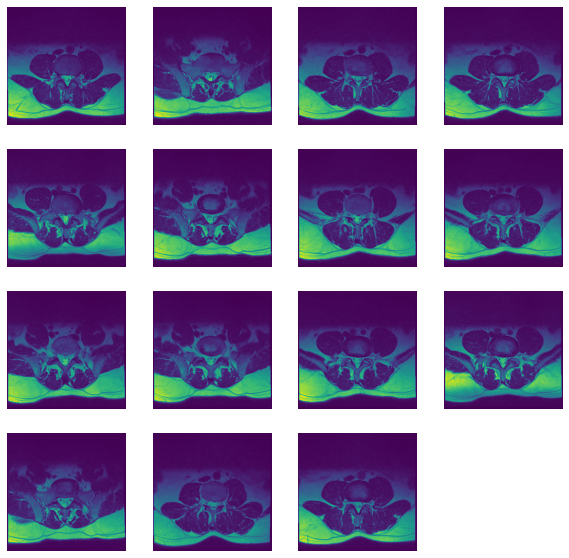

In [ ]:
import glob
path=f'/content/01_MRI_Data/0005/L-SPINE_CLINICAL_LIBRARIES_20160608_132349_824000/T2_TSE_TRA_384_0004/*.ima'
i=1
fig = plt.figure(figsize=(10, 10))
#fig.add_subplot(2, , 1)
for file in glob.glob(path):
  img = pydicom.read_file(file)
  fig.add_subplot(4, 4, i)
  #print(i)
  i+=1
  plt.imshow(img.pixel_array)
  plt.axis('off')
print(i)
plt.show()

In [ ]:
from skimage.transform import resize
from collections import defaultdict
import itertools
from collections import Counter
from tqdm import tqdm

In [ ]:
import os
# Count the no. of directories which are the number of patients.
dirs= os.walk("/content/01_MRI_Data").__next__()[1]
print(len(dirs))
dirs.sort()

505




> 

*   Number images per patient in Lumbar Spine MRI Dataset






In [ ]:
from collections import defaultdict
#path='/content/01_MRI_Data/*/*/*/*.ima'
import glob
patient=[]
image_per_person = defaultdict(list)
for i in range(len(dirs)):
  patientid=dirs[i]
  patient.append(patientid)
  path=f'/content/01_MRI_Data/{patientid}/*/*/*.ima'
  no_of_images=0
  for file in glob.glob(path):
    patientid=int(patientid)
    image_per_person[patientid].append(file)
    #print(image_per_person[patientid])
    #img = pydicom.read_file(file)
    #X=img.pixel_array
  #print("Image",img.pixel_array)
    #X=np.asarray(X)
    #X = preprocess_input(X)
    #X = resize(X, (224,224,3))
    #X = np.expand_dims(X, axis=0)
    #X = np.asarray(X)
    no_of_images=no_of_images+1
  #print("X",X.shape)
    #print("FileName",file)
    #print(X.shape)
  print(f"Count of Images for Patient {patientid}",no_of_images) 

Count of Images for Patient 1 65
Count of Images for Patient 2 72
Count of Images for Patient 3 71
Count of Images for Patient 4 70
Count of Images for Patient 5 71
Count of Images for Patient 6 79
Count of Images for Patient 7 98
Count of Images for Patient 8 73
Count of Images for Patient 9 64
Count of Images for Patient 10 71
Count of Images for Patient 11 116
Count of Images for Patient 12 70
Count of Images for Patient 13 72
Count of Images for Patient 14 84
Count of Images for Patient 15 81
Count of Images for Patient 16 71
Count of Images for Patient 17 128
Count of Images for Patient 19 81
Count of Images for Patient 20 222
Count of Images for Patient 21 74
Count of Images for Patient 22 83
Count of Images for Patient 23 176
Count of Images for Patient 24 70
Count of Images for Patient 25 71
Count of Images for Patient 26 71
Count of Images for Patient 27 182
Count of Images for Patient 29 95
Count of Images for Patient 30 73
Count of Images for Patient 31 107
Count of Images f

In [ ]:
image_per_person.items()

dict_items([(1, ['/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_002.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_005.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_008.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_006.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_012.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_015.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_011.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_003.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/T1_TSE_SAG_320_0003/T1_TSE_SAG__0001_009.ima', '/

In [ ]:

def create_data(image_per_person):
    # new dataset
    #patientid, image1, image2,image3,image4,image5, report = [],[],[],[],[],[],[]
    patientid,extra,images_patient_T1_TSE_TRA,images_patient_T2_TSE_TRA,images_patient_T1_TSE_SAG,images_patient_T2_TSE_SAG, POSDISP_,LOCALIZER_,report = [],[],[],[],[],[],[],[],[]
    images_per_patient = defaultdict(list)
    patientid,images_patient, report = [],[],[]
    i=0
    for pid, imgs in image_per_person.items():
      #print("pid",pid)
      #print("imgs",imgs)
         #contains pid and the images associated with that pid
      patientid.append(pid)
      
      images1,images2,images3,images4,images5,images6,images7=[],[],[],[],[],[],[]
      #print(f"i",len(imgs))
      #j=0
      for img in imgs:
        #print(img)
        

        if img.split('/')[5].startswith('T1_TSE_TRA'):
          images1.append(img)
        elif img.split('/')[5].startswith('T2_TSE_TRA'):
          #print(img.find('T2_TSE_TRA'))
          images2.append(img)
        elif img.split('/')[5].startswith('T1_TSE_SAG'):
          images3.append(img)
        elif img.split('/')[5].startswith('T2_TSE_SAG'):
          images4.append(img)
        elif img.split('/')[5].startswith('POSDISP'):
          images5.append(img)
          #j+=1
        elif img.split('/')[5].startswith('LOCALIZER'):
          images6.append(img)
        else:
          images7.append(img)  

      report.append(df.iloc[i]["Clinician's Notes"])
      i+=1
      #print(f"{i}",j)
      
      #images_patient.append(images)      
      images_patient_T1_TSE_TRA.append(images1)
      images_patient_T2_TSE_TRA.append(images2)
      images_patient_T1_TSE_SAG.append(images3)
      images_patient_T2_TSE_SAG.append(images4)
      POSDISP_.append(images5)
      LOCALIZER_.append(images6)
      extra.append(images7)
      
      #images_per_patient=images_per_patient[pid].append(images)
      #print(images_per_patient[pid])
      #print((images))
    L=[]
    data = pd.DataFrame()
    #print(POSDISP_)
    final_data=pd.DataFrame()
    data['Patient_id'] = patientid
    data['Notes'] = report
    data['T1_TSE_TRA']= images_patient_T1_TSE_TRA
    data['T2_TSE_TRA']= images_patient_T2_TSE_TRA
    data['T1_TSE_SAG']= images_patient_T1_TSE_SAG
    data['T2_TSE_SAG']= images_patient_T1_TSE_SAG
    data['POSDISP_']= POSDISP_
    data['LOCALIZER_']= LOCALIZER_
    data['EXTRA']=extra
    #print(data['POSDISP_']) 
    
    return data

In [ ]:
df_image_notes = create_data(image_per_person)
# combined reports and images data to form a dataframe 

In [ ]:
df_image_notes.head()

Patient_id  ... EXTRA
0           1  ...    []
1           2  ...    []
2           3  ...    []
3           4  ...    []
4           5  ...    []

[5 rows x 9 columns]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df_image_notes[['T1_TSE_TRA','T2_TSE_TRA']]

T1_TSE_TRA                                         T2_TSE_TRA
0    [/content/01_MRI_Data/0001/L-SPINE_LSS_2016030...  [/content/01_MRI_Data/0001/L-SPINE_LSS_2016030...
1    [/content/01_MRI_Data/0002/L-SPINE_CLINICAL_LI...  [/content/01_MRI_Data/0002/L-SPINE_CLINICAL_LI...
2    [/content/01_MRI_Data/0003/L-SPINE_LSS_2016041...  [/content/01_MRI_Data/0003/L-SPINE_LSS_2016041...
3    [/content/01_MRI_Data/0004/L-SPINE_CLINICAL_LI...  [/content/01_MRI_Data/0004/L-SPINE_CLINICAL_LI...
4    [/content/01_MRI_Data/0005/L-SPINE_CLINICAL_LI...  [/content/01_MRI_Data/0005/L-SPINE_CLINICAL_LI...
..                                                 ...                                                ...
500  [/content/01_MRI_Data/0570/L-SPINE_LSS_2016032...  [/content/01_MRI_Data/0570/L-SPINE_LSS_2016032...
501  [/content/01_MRI_Data/0571/L-SPINE_LSS_2015121...  [/content/01_MRI_Data/0571/L-SPINE_LSS_2015121...
502  [/content/01_MRI_Data/0572/L-SPINE_LSS_2016011...  [/content/01_MRI_Data/0572/L-SPINE_LSS_2016011...
503  [/content/01_MRI_Data/0573/L-SPINE_CLINICAL_LI...  [/content/01_MRI_Data/0573/L-SPINE_CLINICAL_LI...
504  [/content/01_MRI_Data/0575/L-SPINE_LSS_2015101...  [/content/01_MRI_Data/0575/L-SPINE_LSS_2015101...

[505 rows x 2 columns]

In [ ]:
import seaborn as sns







*   Number of T1_TSE_TRA images per patient





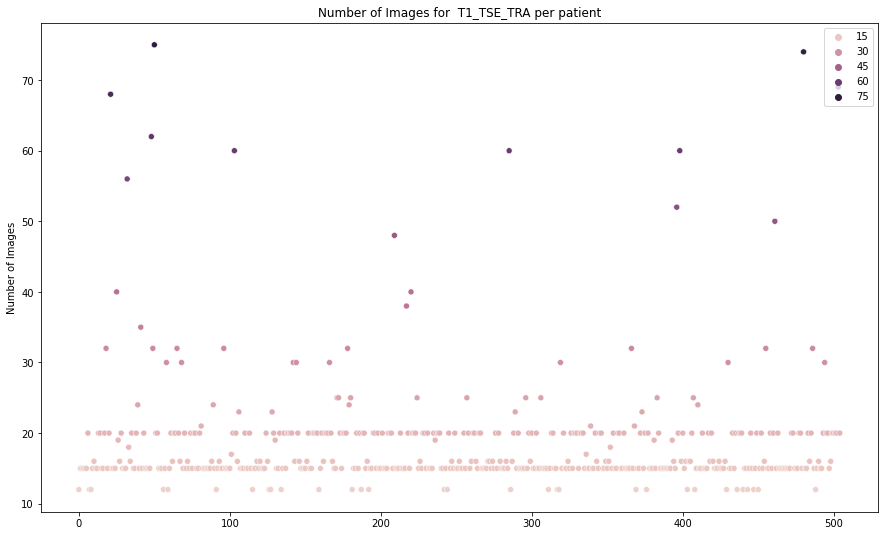

In [ ]:
x = df_image_notes.index
y = [len(e) for e in df_image_notes.T1_TSE_TRA] 
plt.figure(figsize=(15,9))
plt.title('Number of Images for  T1_TSE_TRA per patient')
sns.scatterplot(x,y,hue=y)
plt.ylabel('Number of Images')
plt.legend(loc=1)


*   Number of T2_TSE_TRA images per patient

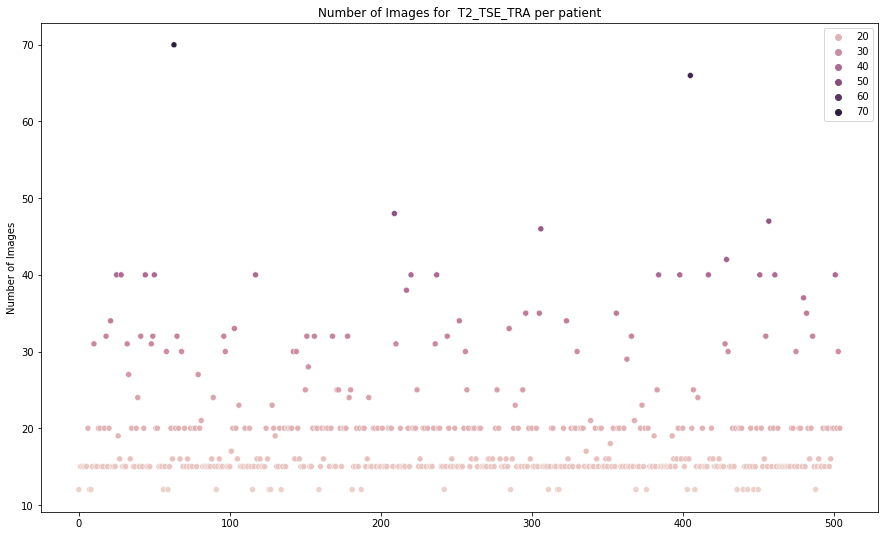

In [ ]:
x = df_image_notes.index
y = [len(e) for e in df_image_notes.T2_TSE_TRA] 
plt.figure(figsize=(15,9))
plt.title('Number of Images for  T2_TSE_TRA per patient')
sns.scatterplot(x,y,hue=y)
plt.ylabel('Number of Images')
plt.legend(loc=1)


*   Number of T1_TSE_SAG images per patient

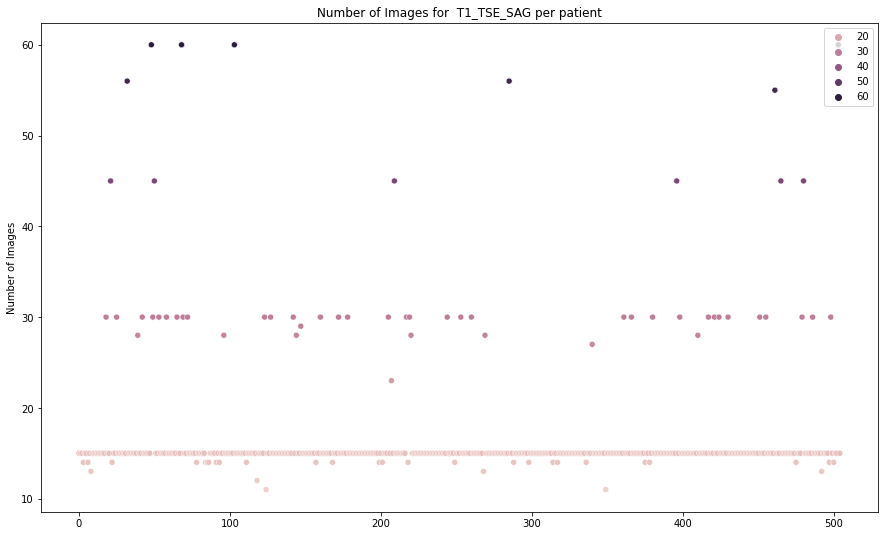

In [ ]:
x = df_image_notes.index
y = [len(e) for e in df_image_notes.T1_TSE_SAG] 
plt.figure(figsize=(15,9))
plt.title('Number of Images for  T1_TSE_SAG per patient')
sns.scatterplot(x,y,hue=y)
plt.ylabel('Number of Images')
plt.legend(loc=1)


*   Number of T2_TSE_SAG images per patient

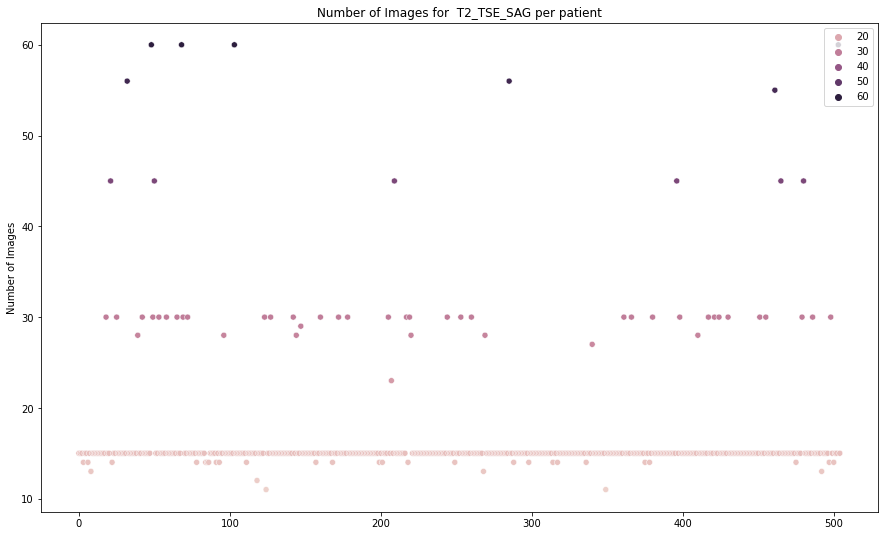

In [ ]:
x = df_image_notes.index
y = [len(e) for e in df_image_notes.T2_TSE_SAG] 
plt.figure(figsize=(15,9))
plt.title('Number of Images for  T2_TSE_SAG per patient')
sns.scatterplot(x,y,hue=y)
plt.ylabel('Number of Images')
plt.legend(loc=1)


*   Number of POSITIONAL images per patient

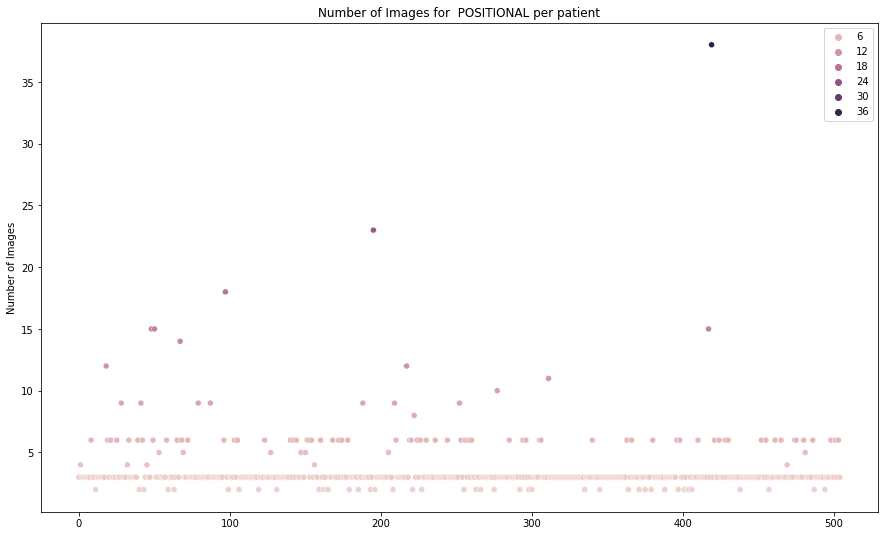

In [ ]:
x = df_image_notes.index
y = [len(e) for e in df_image_notes.POSDISP_] 
plt.figure(figsize=(15,9))
plt.title('Number of Images for  POSITIONAL per patient')
sns.scatterplot(x,y,hue=y)
plt.ylabel('Number of Images')
plt.legend(loc=1)


*   Number of LOCALIZER images per patient

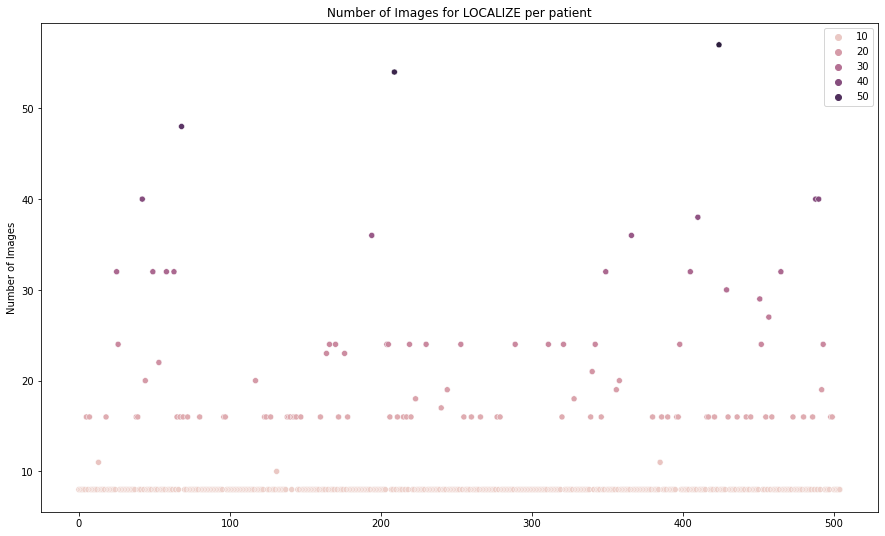

In [ ]:
x = df_image_notes.index
y = [len(e) for e in df_image_notes.LOCALIZER_] 
plt.figure(figsize=(15,9))
plt.title('Number of Images for LOCALIZE per patient')
sns.scatterplot(x,y,hue=y)
plt.ylabel('Number of Images')
plt.legend(loc=1)


In [ ]:
df_image_notes.shape

(505, 9)

In [ ]:
df_image_notes.iloc[0]['Notes']

'L4-L5: degenerative annular disc bulge is noted more to the left side compressing the thecal sac, compressing left nerve root and narrowing right neural foramen. Evidence of hyperintense signal within the annulus fibrosus at left paramedian/posterolateral area which probably represents a torn annulus.'

**4. Using transfer Learning to implement Chexnet Model for Feature Generation**

In [ ]:
from tensorflow.keras.applications import densenet
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import preprocess_input
chex = densenet.DenseNet121(include_top=False, weights = None,   input_shape=(224,224,3), pooling="avg")
X = chex.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chex.input, outputs=X)
model.load_weights('/content/drive/MyDrive/Capstone Project/Problem Statement Finalization/Spinal MRI - Disc abnormality detection/Datasets/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
chexnet = Model(inputs = model.input, outputs = model.layers[-2].output)

In [ ]:
chexnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
len(chexnet.layers)
# Total number of layers in Chexnet Model 

428

In [ ]:
#Layer after 350 Chexnet are made trainable
for layer in chexnet.layers[350:]:
  layer.trainable = True

In [ ]:
#Layer before Chexnet are made non-trainable
for layer in chexnet.layers[:350]:
  layer.trainable = False

In [ ]:
chexnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

#5. Function to load the Image , resize image and then preprocess images as per the Chexnet Input layer

In [ ]:

import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
%matplotlib inline


def load_image_resize(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    #print("monochrome",dicom.PhotometricInterpretation)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME2":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint16)
    data = preprocess_input(data)
    data = resize(data, (224,224,3))
    #plt.imshow(data,cmap=plt.cm.gray)
    #data = np.expand_dims(data,axis= 0)
    data = np.asarray(data)
    # plt.imshow(data,cmap=plt.cm.gray)

    return data

In [ ]:
range(df_image_notes.shape[0])

range(0, 505)

In [ ]:
from sklearn.preprocessing import StandardScaler



*   Scaled Images for every Patient for T1_TSE_TRA



In [ ]:
FM_T1_TSE_TRA=[]
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  for j in range(len(df_image_notes['T1_TSE_TRA'][i])):
    image_shaped=load_image_resize(df_image_notes['T1_TSE_TRA'][i][j])
    #print(image_shaped)
    input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)  
  #FM_T1_TSE_TRA.append(input_/len(df_image_notes['T1_TSE_TRA'][i]))
  FM_T1_TSE_TRA.append(input_)

In [ ]:
  FM_T1_TSE_TRA = np.array(FM_T1_TSE_TRA)
  scaler = StandardScaler()
  FM_T1_TSE_TRA = scaler.fit_transform(FM_T1_TSE_TRA.reshape(-1, FM_T1_TSE_TRA.shape[-1])).reshape(FM_T1_TSE_TRA.shape) 

*   Scaled Images for every Patient for T2_TSE_TRA

In [ ]:
FM_T2_TSE_TRA=[]
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  for j in range(len(df_image_notes['T2_TSE_TRA'][i])):
    image_shaped=load_image_resize(df_image_notes['T2_TSE_TRA'][i][j])
    input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)
  FM_T2_TSE_TRA.append(input_)

In [ ]:
FM_T2_TSE_TRA = np.array(FM_T2_TSE_TRA)
scaler = StandardScaler()
FM_T2_TSE_TRA = scaler.fit_transform(FM_T2_TSE_TRA.reshape(-1, FM_T2_TSE_TRA.shape[-1])).reshape(FM_T2_TSE_TRA.shape) 

*   Scaled Images for every Patient for T1_TSE_SAG

In [ ]:
FM_T1_TSE_SAG = []
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  for j in range(len(df_image_notes['T1_TSE_SAG'][i])):
    image_shaped=load_image_resize(df_image_notes['T1_TSE_SAG'][i][j])
    input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)
  FM_T1_TSE_SAG.append(input_)

In [ ]:
FM_T1_TSE_SAG = np.array(FM_T1_TSE_SAG)
scaler = StandardScaler()
FM_T1_TSE_SAG = scaler.fit_transform(FM_T1_TSE_SAG.reshape(-1, FM_T1_TSE_SAG.shape[-1])).reshape(FM_T1_TSE_SAG.shape) 

*   Scaled Images for every Patient for T2_TSE_SAG

In [ ]:
FM_T2_TSE_SAG = []
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  for j in range(len(df_image_notes['T2_TSE_SAG'][i])):
    image_shaped=load_image_resize(df_image_notes['T2_TSE_SAG'][i][j])
    input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)
  FM_T2_TSE_SAG.append(input_)

In [ ]:
FM_T2_TSE_SAG = np.array(FM_T2_TSE_SAG)
scaler = StandardScaler()
FM_T2_TSE_SAG = scaler.fit_transform(FM_T2_TSE_SAG.reshape(-1, FM_T2_TSE_SAG.shape[-1])).reshape(FM_T2_TSE_SAG.shape) 

*   Scaled Images for every Patient for POSITIONAL

In [ ]:
FM_POSDISP_=[]
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  for j in range(len(df_image_notes['POSDISP_'][i])):
    image_shaped=load_image_resize(df_image_notes['POSDISP_'][i][j])
    input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)  
  FM_POSDISP_.append(input_)

In [ ]:
FM_POSDISP_ = np.array(FM_POSDISP_)
scaler = StandardScaler()
FM_POSDISP_ = scaler.fit_transform(FM_POSDISP_.reshape(-1, FM_POSDISP_.shape[-1])).reshape(FM_POSDISP_.shape) 

*   Scaled Images for every Patient for LOCALIZER

In [ ]:
FM_LOCALIZER_=[]
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  for j in range(len(df_image_notes['LOCALIZER_'][i])):
    image_shaped=load_image_resize(df_image_notes['LOCALIZER_'][i][j])
    input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)  
  FM_LOCALIZER_.append(input_)

In [ ]:
FM_LOCALIZER_ = np.array(FM_LOCALIZER_)
scaler = StandardScaler()
FM_LOCALIZER_ = scaler.fit_transform(FM_LOCALIZER_.reshape(-1, FM_LOCALIZER_.shape[-1])).reshape(FM_LOCALIZER_.shape) 

In [ ]:
FM_T1_TSE_TRA.shape

(505, 224, 224, 3)



*  Saving all the six views image Feature 



In [ ]:

# save the file for future use
f = open('FM_POSDISP_.pickle','wb')
pickle.dump(FM_POSDISP_, f)
f.close()

In [ ]:

# save the file for future use
f = open('FM_T1_TSE_TRA.pickle','wb')
pickle.dump(FM_T1_TSE_TRA, f)
f.close()

In [ ]:

# save the file for future use
f = open('FM_T2_TSE_TRA.pickle','wb')
pickle.dump(FM_T2_TSE_TRA, f)
f.close()

In [ ]:

# save the file for future use
f = open('FM_T1_TSE_SAG.pickle','wb')
pickle.dump(FM_T1_TSE_SAG, f)
f.close()

In [ ]:

# save the file for future use
f = open('FM_T2_TSE_SAG.pickle','wb')
pickle.dump(FM_T2_TSE_SAG, f)
f.close()



*   Loading the Image Features saved above



In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_T1_TSE_TRA.pickle','rb') # contains the features from chexNet
FM_T1_TSE_TRA = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_T2_TSE_TRA.pickle','rb') # contains the features from chexNet
FM_T2_TSE_TRA = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_T1_TSE_SAG.pickle','rb') # contains the features from chexNet
FM_T1_TSE_SAG = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_T2_TSE_SAG.pickle','rb') # contains the features from chexNet
FM_T2_TSE_SAG = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_LOCALIZER_.pickle','rb') # contains the features from chexNet
FM_LOCALIZER_ = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_POSDISP_.pickle','rb') # contains the features from chexNet
FM_POSDISP_ = pickle.load(f)
f.close()

 
#6. Text Cleaning and Processing of reports



In [ ]:
def lowercase(text):
    '''Converts to lowercase'''
    new_text = []
    for line in text:
        line=str(line)
        new_text.append(line.lower())
    return new_text

def decontractions(text):
    '''Performs decontractions in the doc'''
    new_text = []
    for phrase in text:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase)
        new_text.append(phrase)

    return new_text

def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations: 
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_numbers(text):
    '''Removes numbers and irrelevant text like xxxx*'''
    new_text = []
    for line in text:
        temp = re.sub(r'x*','',line)
        new_text.append(re.sub(r'\d','',temp))
    return new_text

def words_filter(text):
    '''Removes words less than 2 characters except no and ct'''
    new_text = []
    for line in text:
        temp = line.split()
        temp2 = []
        for word in temp:
            if  len(word) <=2 and word != 'no' and word != 'ct':
                continue
            else:
                temp2.append(word)
        new_text.append(' '.join(e for e in temp2))
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def fullstops(text):
    new_text = []
    for line in text:
        new_text.append(re.sub('\.', ' .', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

In [ ]:
def text_preprocessing(text):
    '''Combines all the preprocess functions'''
    new_text = lowercase(text)
    new_text = decontractions(new_text)
    new_text = rem_punctuations(new_text)
    #new_text = rem_numbers(new_text)
    new_text = words_filter(new_text)
    new_text = multiple_fullstops(new_text)
    new_text = fullstops(new_text)
    new_text = multiple_spaces(new_text)
    new_text = separting_startg_words(new_text)
    new_text = rem_apostrophes(new_text)
    return new_text

In [ ]:
train=df_image_notes

In [ ]:
train['Notes'] = text_preprocessing(train['Notes'])

In [ ]:
train.columns

Index(['Patient_id', 'Notes', 'T1_TSE_TRA', 'T2_TSE_TRA', 'T1_TSE_SAG',
       'T2_TSE_SAG', 'POSDISP_', 'LOCALIZER_', 'EXTRA'],
      dtype='object')

In [ ]:
train.isnull().sum()

Patient_id    0
Notes         0
T1_TSE_TRA    0
T2_TSE_TRA    0
T1_TSE_SAG    0
T2_TSE_SAG    0
POSDISP_      0
LOCALIZER_    0
EXTRA         0
dtype: int64

In [ ]:
train.head()

Patient_id  ... EXTRA
0           1  ...    []
1           2  ...    []
2           3  ...    []
3           4  ...    []
4           5  ...    []

[5 rows x 9 columns]

In [ ]:
train.shape

(505, 9)

In [ ]:
l = [len(e.split()) for e in train['Notes'].values] 

In [ ]:
max(l) #After Cleaning and processing of reports max lenght for patient 135

135




*  Length of reports per patient



Text(0, 0.5, 'Number of words')

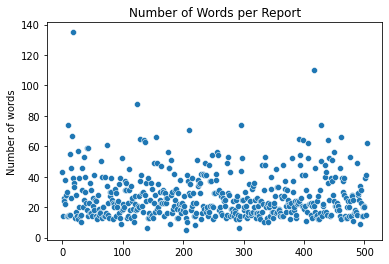

In [ ]:
plt.title('Number of Words per Report')
sns.scatterplot(range(train.shape[0]), l)
plt.ylabel('Number of words')

In [ ]:

l = []
for i in train['Notes'].values:
    l.extend(i.split())

In [ ]:
w = WordCloud(height=1500, width=1500).generate(str(l))

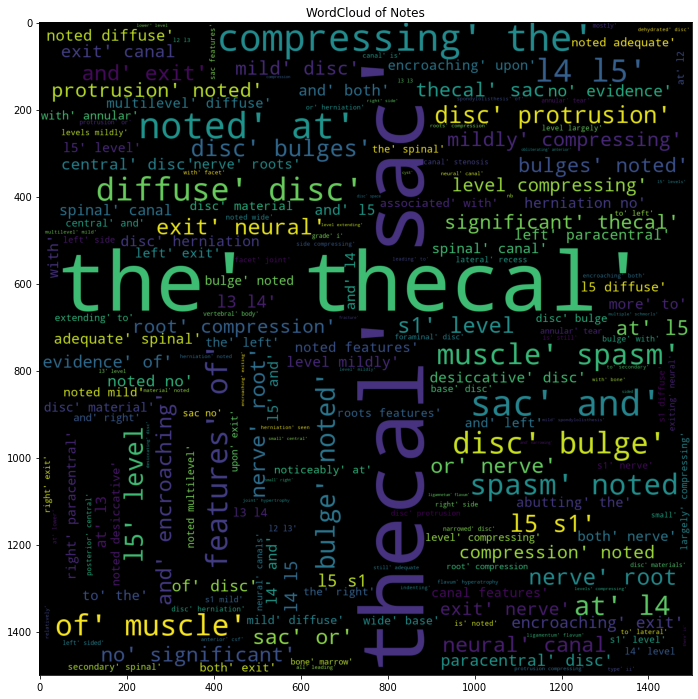

In [ ]:
plt.figure(figsize=(12,12))
plt.title('WordCloud of Notes')
plt.imshow(w)

In [ ]:
# adding startseq and endseq at starting and end of each report
def remodelling(x):
    '''adds start and end tokens to a sentence '''
    return 'startseq' + ' ' + x + ' ' + 'endseq'

In [ ]:
train.iloc[0]['Notes']

'l4-l5: degenerative annular disc bulge is noted more to the left side compressing the thecal sac, compressing left nerve root and narrowing right neural foramen. evidence of hyperintense signal within the annulus fibrosus at left paramedian/posterolateral area which probably represents a torn annulus.'

In [ ]:
train['Notes'] = train['Notes'].apply(lambda x : remodelling(x))

In [ ]:
train.iloc[0]['Notes']

'startseq l4-l5: degenerative annular disc bulge is noted more to the left side compressing the thecal sac, compressing left nerve root and narrowing right neural foramen. evidence of hyperintense signal within the annulus fibrosus at left paramedian/posterolateral area which probably represents a torn annulus. endseq'

#7. Train Test Split

In [ ]:
X_train_img, X_cv_img, y_train_rep, y_cv_rep = train_test_split(train.index, train.Notes,
                                                                test_size = 0.1, random_state=97) 

In [ ]:
X_train_img

Int64Index([224, 183, 152, 466, 272, 278,  70,  98, 380, 211,
            ...
            260, 325, 501, 284, 199, 437, 179, 105, 419,  90],
           dtype='int64', length=454)

In [ ]:
y_train_rep

224    startseq features of muscle spasm noted. l1-l2...
183    startseq multilevel mild disc bulges noted abu...
152    startseq l3-l4 level :wide based disc bulge no...
466    startseq features of muscle spasm noted. desic...
272    startseq features of muscle spasm noted. desic...
                             ...                        
437    startseq no evidence of disc herniation. no si...
179    startseq feaure of muscle spasm. multilevels d...
105    startseq l3-l4: mild disc bulge noted. l4-l5: ...
419    startseq no evidence of disc herniation. no si...
90     startseq diffuse disc bulge noted at l3-l4 lev...
Name: Notes, Length: 454, dtype: object

In [ ]:
y_train_rep[11]

'startseq right paracentral disc protrusion noted at l4-l5 level, compressing the thecal sac. adequate spinal canal. endseq'

In [ ]:
max_capt_len = 135
pad_size = max_capt_len

#8. Tokenzation and generation of padded data for output.

In [ ]:
tokenizer = Tokenizer(filters='!"#$%&()*+,/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train.Notes.values)

In [ ]:
len(tokenizer.word_index.keys())

695

#9. Data Generator

In [ ]:

BATCH_SIZE = 5
BUFFER_SIZE = 500

In [ ]:
def load_image(id_1,id_2,id_3,id_4,id_5,id_6,report):
    '''Loads the Image Features with their corresponding Ids'''
    #print(f"index{id_}")
    FM_T1_TSE_TRA_IF = FM_T1_TSE_TRA[id_1][0]
    FM_T2_TSE_TRA_IF = FM_T2_TSE_TRA[id_2][0]
    FM_T1_TSE_SAG_IF = FM_T1_TSE_SAG[id_3][0]
    FM_T2_TSE_SAG_IF = FM_T2_TSE_SAG[id_4][0]
    FM_POSDISP_IF = FM_POSDISP_[id_5][0]
    FM_LOCALIZER_IF = FM_LOCALIZER_[id_6][0]
    #print(f"index{id_1}",FM_T1_TSE_TRA[id_1][0].shape)
    #print(f"index{id_}",Xnet_Features[id_][0].shape)
    return FM_T1_TSE_TRA_IF,FM_T2_TSE_TRA_IF,FM_T1_TSE_SAG_IF,FM_T2_TSE_SAG_IF,FM_POSDISP_IF,FM_LOCALIZER_IF,report
    

In [ ]:
def create_dataset(img_name_train,reps):
    dataset = tf.data.Dataset.from_tensor_slices((img_name_train,img_name_train,img_name_train,img_name_train,img_name_train,img_name_train, reps))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2,item3,item4,item5,item6,item7: tf.numpy_function(load_image, [item1, item2, item3, item4, item5,item6,item7], [ tf.float64, tf.float64,tf.float64, tf.float64, tf.float64, tf.float64, tf.float64,tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [ ]:
vocab_size

696

In [ ]:
train_dataset = create_dataset(X_train_img,y_train_rep)
cv_dataset = create_dataset(X_cv_img, y_cv_rep)

In [ ]:
train_dataset

<PrefetchDataset shapes: (<unknown>, <unknown>, <unknown>, <unknown>, <unknown>, <unknown>, <unknown>, <unknown>), types: (tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.float64, tf.string)>

#10. Word embedding Generation using Pubmed

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
embeddings_index = dict()
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Capstone Project/Problem Statement Finalization/Spinal MRI - Disc abnormality detection/Datasets/BioWordVec_PubMed_MIMICIII_d200.vec.bin',binary=True)
# Loaded word Vectors for Pubmed which of 13 GB

In [ ]:
word_dict = {}
for word in word_vectors.vocab:
  word_dict[word] = word_vectors[word]

In [ ]:
print('Loaded %s word vectors.' % len(embeddings_index))
#Loaded 16545452 word vectors.

In [ ]:

vocab_size = len(tokenizer.word_index.keys()) + 1
embedding_matrix = np.zeros((vocab_size,200))
for word, i in tokenizer.word_index.items():
    if word in embeddings_index.keys():
        vec = embeddings_index[word]
        embedding_matrix[i] = vec
    else:
        continue

In [ ]:
np.save('embeddings696.npy', embedding_matrix)  # Saved the embedding Matrix generated

In [ ]:
# Loaded the saved word embedding generated
all_embeddings = np.load('/content/drive/MyDrive/Capstone Project/pickle_files/embeddings696.npy') 

In [ ]:
all_embeddings.shape

(696, 200)

In [ ]:
train_dataset

<PrefetchDataset shapes: (<unknown>, <unknown>, <unknown>, <unknown>, <unknown>), types: (tf.float64, tf.float64, tf.float64, tf.float64, tf.string)>

#11. Model

In [ ]:
input1 = Input(shape=(224,224,3), name='Image_1')
chexnet_model1=chexnet(input1) # T1_TSE_TRA images
input2 = Input(shape=(224,224,3), name='Image_2')
chexnet_model2=chexnet(input2) # T2_TSE_TRA images
input3 = Input(shape=(224,224,3), name='Image_3')
chexnet_model3=chexnet(input3) # T1_TSE_SAG images
input4 = Input(shape=(224,224,3), name='Image_4')
chexnet_model4=chexnet(input4) # T2_TSE_SAG images
input5 = Input(shape=(224,224,3), name='Image_5')
chexnet_model5=chexnet(input5) # POSITIONAL images
input6 = Input(shape=(224,224,3), name='Image_6')
chexnet_model6=chexnet(input6) # LOCALIZER images

add_six_chexnet_output=tf.keras.layers.Add()([chexnet_model1,chexnet_model2,chexnet_model3,chexnet_model4,chexnet_model5,chexnet_model6])
dense1 = Dense(512, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56),
               name='dense_encoder')(add_six_chexnet_output)

input_text = Input(shape=(135), name='Text_Input') # report with startseq and endseq
emb_layer = Embedding(input_dim = vocab_size, output_dim = 200, input_length=135, mask_zero=True,trainable=False,
                     weights=[all_embeddings], name="Embedding_layer")
emb = emb_layer(input_text)
LSTM1 = Bidirectional( LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1"))(emb)
#LSTM1_output = LSTM1(emb)
LSTM2 = Bidirectional( LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(),name="LSTM2"))
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.2, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63),
            name='fc1')
fc1_output = fc1(dec)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(fc1_output)

encoder_decoder = Model(inputs = [input1, input2,input3,input4,input5,input6,input_text], outputs = output)

In [ ]:
encoder_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 135)]        0                                            
__________________________________________________________________________________________________
Image_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
____________________________________________________________________________________________

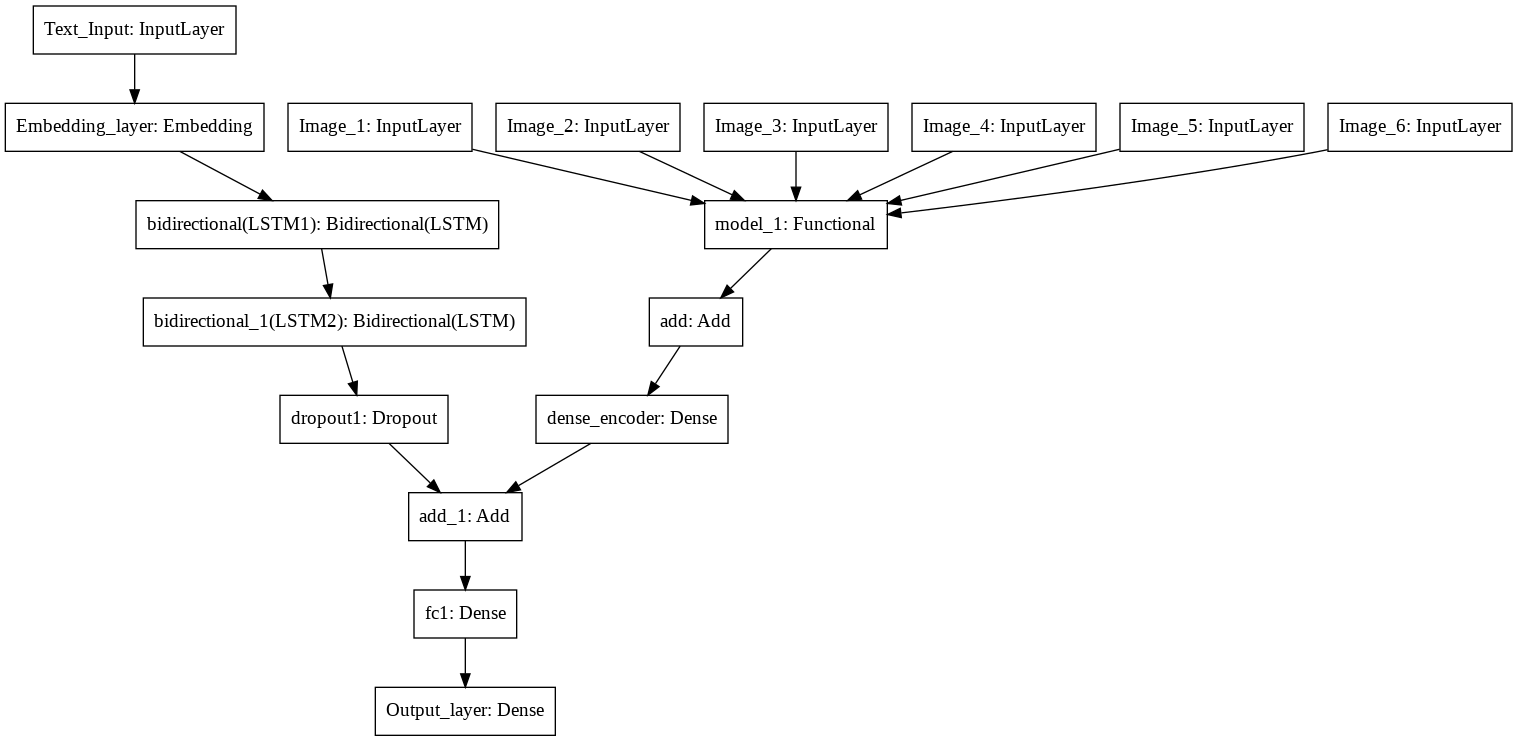

In [ ]:
  tf.keras.utils.plot_model(
      encoder_decoder, to_file='model.png', show_shapes=False, show_dtype=False,
      show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
  )

In [ ]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

In [ ]:
def convert(images1,images2,images3,images4,images5,images6, reports):
    '''This function takes the batch of data and converts them into a new dataset(A WORD BY WORD DATASET)'''
    imgs1,imgs2,imgs3,imgs4,imgs5,imgs6 = [],[],[],[],[],[]
    in_reports = []
    out_reports = []
    for i in range(len(images1)):
        #print(type(reports[i]))
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]
        #print(sequence)
        for j in range(1,len(sequence)):

            in_seq = sequence[:j]
            out_seq = sequence[j]
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs1.append(images1[i])
            imgs2.append(images2[i])
            imgs3.append(images3[i])
            imgs4.append(images4[i])
            imgs5.append(images5[i])
            imgs6.append(images6[i])
   
          #  print(in_seq)
            in_reports.append(in_seq)
           # print(out_seq)
            out_reports.append(out_seq)
        
    return np.array(imgs1),np.array(imgs2),np.array(imgs3),np.array(imgs4),np.array(imgs5),np.array(imgs6),np.array(in_reports), np.array(out_reports)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='auto')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    print("masked value",mask)
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [ ]:
encoder_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 135)]        0                                            
__________________________________________________________________________________________________
Image_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
____________________________________________________________________________________________

In [ ]:
encoder_decoder.compile(optimizer=optimizer, loss=maskedLoss)

In [ ]:

EPOCH=35

In [ ]:
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(EPOCH):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    
    for img1,img2,img3,img4,img5,img6 ,report in train_dataset:
        #print(img1)
        r1 = bytes_to_string(report.numpy())
        #print("Type",type(r1))
        #img_input, rep_input, output_word = (img.numpy(),report.numpy(), report.numpy())
        img_input1,img_input2,img_input3,img_input4, img_input5,img_input6,rep_input, output_word=convert(img1.numpy(),img2.numpy(),img3.numpy(),img4.numpy(),img5.numpy(),img6.numpy(),r1)
        #img_input, rep_input = (img.numpy(), report.numpy())
        rep_input = pad_sequences(rep_input, maxlen=135, padding='post')
        results = encoder_decoder.train_on_batch([img_input1,img_input2,img_input3,img_input4,img_input5,img_input6,rep_input], output_word)
        #results = encoder_decoder.train_on_batch([img, report])
        #print(results)
        batch_loss_tr += results
    train_loss = batch_loss_tr/(X_train_img.shape[0]//BATCH_SIZE)
    
    for img1,img2,img3,img4,img5,img6 ,report in cv_dataset:
        
        r1 = bytes_to_string(report.numpy())
        #img_input, rep_input, output_word = convert(img.numpy(), r1)
        img_input1,img_input2,img_input3,img_input4, img_input5,img_input6,rep_input, output_word=convert(img1.numpy(),img2.numpy(),img3.numpy(),img4.numpy(),img5.numpy(),img6.numpy(),r1)
        rep_input = pad_sequences(rep_input, maxlen=135, padding='post')
        results = encoder_decoder.train_on_batch([img_input1,img_input2,img_input3,img_input4,img_input5,img_input6,rep_input], output_word)
        batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_cv_img.shape[0]//BATCH_SIZE)

    epoch_train_loss.append(train_loss)
    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    #encoder_decoder.save_weights('BM7_new_model1_epoch_'+ str(epoch+1) + '.h5')

EPOCH :  1
masked value Tensor("maskedLoss/LogicalNot:0", shape=(142, 696), dtype=bool)
masked value Tensor("maskedLoss/LogicalNot:0", shape=(142, 696), dtype=bool)
masked value Tensor("maskedLoss/LogicalNot:0", shape=(179, 696), dtype=bool)
masked value Tensor("maskedLoss/LogicalNot:0", shape=(None, 696), dtype=bool)
Training Loss: 0.006784957031615906
Validation Loss: 0.006561908405274153
Time Taken for this Epoch : 213.48224067687988 sec
EPOCH :  2
Training Loss: 0.005340006538770265
Validation Loss: 0.005017675808630884
Time Taken for this Epoch : 135.28898310661316 sec
EPOCH :  3
Training Loss: 0.004218821455207136
Validation Loss: 0.004018598305992782
Time Taken for this Epoch : 118.43521428108215 sec
EPOCH :  4
Training Loss: 0.003521456798383345
Validation Loss: 0.003723467048257589
Time Taken for this Epoch : 120.79238271713257 sec
EPOCH :  5
Training Loss: 0.0032484139057083264
Validation Loss: 0.003188031754689291
Time Taken for this Epoch : 122.17252016067505 sec
EPOCH :  6

In [ ]:
filepath='/content/model_weights.h5'

In [ ]:
encoder_decoder.save(
    filepath, overwrite=True, include_optimizer=True, save_format='h5',
    signatures=None, options=None, save_traces=True
)
# Saving final model weights

In [ ]:
encoder_decoder.input[4]

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'Image_5')>

a) Encoder Model

In [ ]:
encoder_input1 = encoder_decoder.input[0]
encoder_input2 = encoder_decoder.input[1]
encoder_input3 = encoder_decoder.input[2]
encoder_input4 = encoder_decoder.input[3]
encoder_input5 = encoder_decoder.input[4]
encoder_input6 = encoder_decoder.input[5]
encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_model = Model(inputs = [encoder_input1,encoder_input2,encoder_input3,encoder_input4,encoder_input5,encoder_input6], outputs = encoder_output )



In [ ]:
encoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
____________________________________________________________________________________________

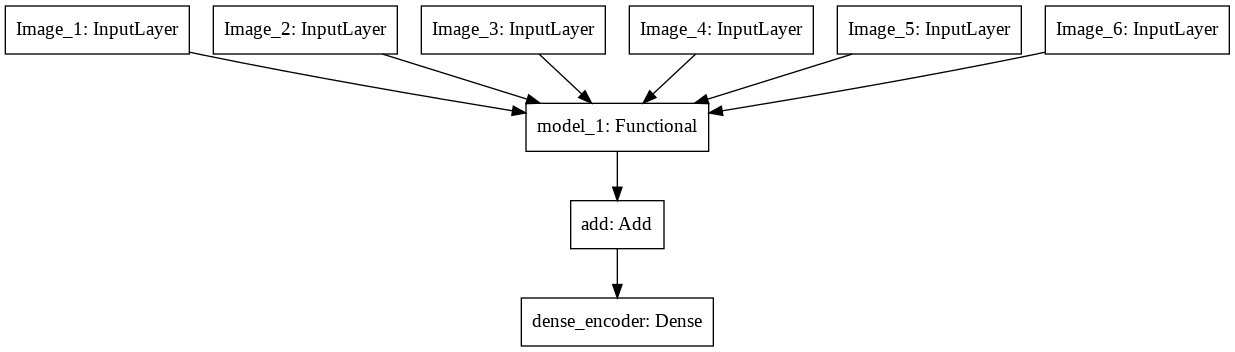

In [ ]:
  tf.keras.utils.plot_model(
      encoder_model, to_file='model.png', show_shapes=False, show_dtype=False,
      show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
  )

b) Decoder Model

In [ ]:
# decoder# 
text_input = encoder_decoder.input[4]
enc_output = Input(shape=(512,), name='Enc_Output')
text_output = encoder_decoder.get_layer('bidirectional_1').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

In [ ]:
decoder_model.summary()

In [ ]:
  tf.keras.utils.plot_model(
      decoder_model, to_file='model.png', show_shapes=False, show_dtype=False,
      show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
  )

In [ ]:
def greedysearch(img):
    image1 = FM_T1_TSE_TRA[img]
    image2 = FM_T2_TSE_TRA[img]
    image3 = FM_T1_TSE_SAG[img]
    image4 = FM_T2_TSE_SAG[img]
    #image5 = FM_POSDISP_[img]
    #image6 = FM_LOCALIZER_[img]
    input_ = 'startseq'
    #image_features = encoder_model.predict([image1,image2,image3,image4,image5,image6])
    image_features = encoder_model.predict([image1,image2,image3,image4])

    result = []
    for i in range(135):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 135, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        #print(predictions)
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
            #print(input_)
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

In [ ]:
res = greedysearch(400) # result after 20 epochs
res

'features of muscle spasm noted. desiccative disc material at l5-s1 level. diffuse disc bulge noted at l4-l5 compressing the thecal sac and encroaching exit neural canals.'

In [ ]:
train.iloc[400]['Notes']

'startseq mild disc bulge noted at l4-l5 level. no significant thecal sac or nerve root compression noted. adequate spinal canal. endseq'

In [ ]:
res = greedysearch(421) 
res

'features of muscle spasm noted. diffuse disc bulge noted at l4-l5 mildly compressing the thecal sac and exit nerve roots.'

In [ ]:
train.iloc[421]['Notes']

'startseq features of muscle spasm noted. diffuse disc bulges noted at l4-l5 and l5-s1 levels, compressing the thecal sac and encroaching both exit neural canals. endseq'

In [ ]:
def rem_fullstops(text):
    '''Removes punctuations'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations: 
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

In [ ]:
train.head()

Patient_id  ... EXTRA
0           1  ...    []
1           2  ...    []
2           3  ...    []
3           4  ...    []
4           5  ...    []

[5 rows x 9 columns]

In [ ]:
X_cv_img

Int64Index([495, 121, 175, 492, 198,  47, 329, 499,  58, 162, 363,  16,  55,
            233, 355, 332, 385, 358, 163, 455, 502, 166, 500, 324, 494, 176,
            158, 160, 111, 477, 232,  57, 298, 394, 395, 228,  34, 153, 489,
            342, 319, 115, 123, 473,   1, 305, 460,   6, 150, 312, 234],
           dtype='int64')

In [ ]:
X_cv_img[0]

495

In [ ]:
greedysearch(495)

'features of muscle spasm noted. desiccative disc material at l5-s1 level. diffuse disc bulge noted at l4-l5 compressing the thecal sac and encroaching exit neural canals.'

In [ ]:
X_cv_img

Int64Index([495, 121, 175, 492, 198,  47, 329, 499,  58, 162, 363,  16,  55,
            233, 355, 332, 385, 358, 163, 455, 502, 166, 500, 324, 494, 176,
            158, 160, 111, 477, 232,  57, 298, 394, 395, 228,  34, 153, 489,
            342, 319, 115, 123, 473,   1, 305, 460,   6, 150, 312, 234],
           dtype='int64')

#12. Model Evaluation

In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for i in tqdm(range(X_cv_img.shape[0])):
    
    rep = rem_fullstops(y_cv_rep.iloc[i])
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = greedysearch(X_cv_img[i])
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

100%|██████████| 51/51 [01:00<00:00,  1.19s/it]


In [ ]:
print('Bleu1 Score: ', sum(bleu1)/X_cv_img.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_cv_img.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_cv_img.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_cv_img.shape[0])

Bleu1 Score:  0.41498027357942174
Bleu2 Score:  0.33682578328980756
Bleu3 Score:  0.30555073431155616
Bleu4 Score:  0.27290483259851084


In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for i in tqdm(range(X_train_img.shape[0])):
    
    rep = rem_fullstops(y_train_rep.iloc[i])
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = greedysearch(X_train_img[i])
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

100%|██████████| 454/454 [09:29<00:00,  1.25s/it]


In [ ]:
X_train_img.shape[0]

454

In [ ]:
print('Bleu1 Score: ', sum(bleu1)/X_train_img.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_train_img.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_train_img.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_train_img.shape[0])

Bleu1 Score:  0.3888332462088636
Bleu2 Score:  0.31214092182661424
Bleu3 Score:  0.28326091332473763
Bleu4 Score:  0.2616308616213201


In [ ]:
def beamsearch(img, beam_width):
    
    start = [tokenizer.word_index['startseq']]

    sequences = [[start, 0]]
    
    image1 = FM_T1_TSE_TRA[img]
    image2 = FM_T2_TSE_TRA[img]
    image3 = FM_T1_TSE_SAG[img]
    image4 = FM_T2_TSE_SAG[img]
    image5 = FM_POSDISP_[img]
    image6 = FM_LOCALIZER_[img]
    img_features = encoder_model.predict([image1,image2,image3,image4,image5,image6])
    finished_seq = []
    
    for i in range(135):
        all_candidates = []
        new_seq = []
        for s in sequences:

            text_input = pad_sequences([s[0]], 135, padding='post')
            predictions = decoder_model.predict([text_input,img_features])
            top_words = np.argsort(predictions[0])[-beam_width:]
            seq, score = s
            
            for t in top_words:
                candidates = [seq + [t], score - np.log(predictions[0][t])]
                all_candidates.append(candidates)
                
        sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
        # checks for 'endseq' in each seq in the beam
        count = 0
        for seq,score in sequences:
            if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                score = score/len(seq)   # normalized
                finished_seq.append([seq, score])
                count+=1
            else:
                new_seq.append([seq, score])
        beam_width -= count
        sequences = new_seq
        
        # if all the sequences reaches its end before 155 timesteps
        if not sequences:
            break
        else:
            continue
        
    sequences = finished_seq[-1] 
    rep = sequences[0]
    score = sequences[1]
    temp = []
    rep.pop(0)
    for word in rep:
        if word != tokenizer.word_index['endseq']:
            temp.append(tokenizer.index_word[word])
        else:
            break    
    rep = ' '.join(e for e in temp)        
    
    return rep, score

In [ ]:
res0 = beamsearch(99, 5) # beam_width = 5 
res0